# Data visualization with destiny

## [tiny.cc/destiny-workshop](http://tiny.cc/destiny-workshop)

Resources:
- [Data processing](https://hemberg-lab.github.io/scRNA.seq.course/introduction-to-rbioconductor.html)
- [Scialdone paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4947525/)

## Diffusion maps?

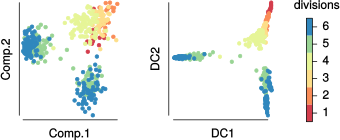

In [1]:
IRdisplay::display_svg(file = 'pca.svg')

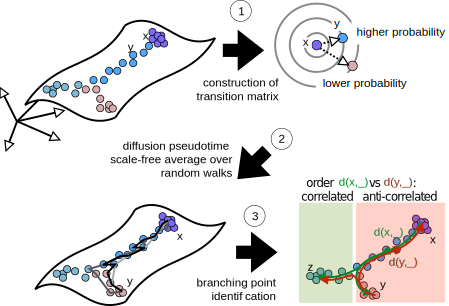

In [2]:
IRdisplay::display_svg(file = 'dpt-explanation.svg')

## Introduction

In [ ]:
library(Matrix)
library(tidyverse)
library(destiny)
library(M3Drop)
library(pheatmap)
suppressPackageStartupMessages(
    library(SingleCellExperiment)
)

Some fixes around bugs and inconveniences in other packages

In [ ]:
c('left_join') %>% map(function(name) {
    func <- get(name)
    assign(paste0(name, '.DataFrame'), function(x, ...) {
        as(func(as.data.frame(x), ...), 'DataFrame')
    }, .GlobalEnv)
}) %>% invisible

setMethod('rowData', 'SingleCellExperiment', function(x, use.names = TRUE) {
    r <- callNextMethod()
    if (isTRUE(use.names)) rownames(r) <- rownames(x)
    r
})

The clusters in the paper are named. Let’s create a mapping from names to pretty colors

In [ ]:
prettier_colors <- c(
    setNames(RColorBrewer::brewer.pal(8, 'Dark2')[c(1,4,6,8)], c('turquoise', 'magenta', 'yellow', 'black')),
    setNames(RColorBrewer::brewer.pal(9, 'Set1')[-c(4,6)], c('red', 'blue', 'green', 'darkorange', 'brown', 'pink', 'grey'))
)
scale_colour_cluster <- function(...) scale_color_manual(values = prettier_colors, ...)
scale_fill_cluster   <- function(...)  scale_fill_manual(values = prettier_colors, ...)

## Loading the data

Let’s load the data. In the future, we’ll use [loomR](https://satijalab.org/loomR/loomR_tutorial.html) to read & write SingleCellExperiments.

In [ ]:
scialdone_raw <- readRDS('scialdone-raw.rds')

Cleaning and normalization

In [ ]:
cleaned <- M3DropCleanData(
    as.matrix(counts(scialdone_raw)),
    labels = colnames(scialdone_raw),
    min_detected_genes = 100,
    is.counts = TRUE
)$data

**Exercise**: How many genes and cells have been removed by this cleaning?

In [ ]:
scialdone <- SingleCellExperiment(
    assays = list(counts = as(cleaned, 'sparseMatrix')),
    rowData = rowData(scialdone_raw, use.names = TRUE)[rownames(cleaned), ],
    colData = colData(scialdone_raw)[colnames(cleaned), ]
)

In [ ]:
logcounts(scialdone) <- log1p(counts(scialdone))

## Use a list of interesting genes
Let’s add some information.

In [ ]:
cluster_sets <- tribble(
    ~cluster,    ~CellType,
    'brown',     'blood',
    'yellow',    'blood',
    'turquoise', 'primitive_streak',
    'magenta',   'primitive_streak',
    'blue',      'primitive_streak'
)

colData(scialdone)$CellType <-
    colData(scialdone) %>%
    left_join(cluster_sets, by = 'cluster') %>%
    .$CellType

**Exercise**: Add information about Gene sets to the `rowData`.

- blood: Hbb-bh1, Hba-x
- primitive_streak: T, Mixl1, Mesp1, Frzb

The information should be in `rowData(scialdone)$GeneSet`

In [ ]:
scialdone_interesting <- scialdone[
    !is.na(rowData(scialdone)$GeneSet),
    !is.na(colData(scialdone)$CellType)
]

colors <- c(
    blood            = prettier_colors[['red']],
    primitive_streak = prettier_colors[['blue']]
)

pheatmap(
    t(logcounts(scialdone_interesting)),
    color = viridis::inferno(255),
    labels_row = rep('', ncol(scialdone_interesting)),
    annotation_row = as.data.frame(colData(scialdone_interesting)['CellType']),
    labels_col = rowData(scialdone_interesting)$Symbol,
    annotation_col = as.data.frame(rowData(scialdone_interesting)['GeneSet']),
    annotation_colors = list(GeneSet = colors, CellType = colors)
)

**Exercise**: Modify the code above to plot another cell annotation. Look at the `colData` of the data container to find out which ones exist.

In [ ]:
dm_interesting <- DiffusionMap(scialdone_interesting)

In [ ]:
plot(dm_interesting, 1:2, col_by = 'cluster') + scale_fill_cluster()
# ~= ggplot(dm, aes(DC1, DC2, colour = cluster)) + geom_point() + scale_colour_cluster()

## Gene Relevance

In [ ]:
gr <- gene_relevance(dm_interesting, dims = 1:2)
featureNames(gr) <- rowData(scialdone_interesting)$Symbol

In [ ]:
plot(gr)$ids
plot(gr)

# Use highly variable genes

**Exercise**: use <code>[BrenneckeGetVariableGenes](https://rdrr.io/bioc/M3Drop/man/Brennecke_getVariableGenes.html)</code> to create a `scialdone_hvg` SingleCellExperiment with further reduced genes.

Use the normalized and logarithmized counts from the `scialdone` SingleCellExperiment.

In [ ]:
dm <- DiffusionMap(scialdone_hvg, distance = 'rankcor')

In [ ]:
plot(dm, 1:2, col_by = 'cluster') + scale_fill_cluster()

**Exercise**: Create a DPT object for one of the datasets and plot it. Also consult the `dim.DPT` help page (execute `?dim.DPT`) to get the DPT distances from cell 20 to all other cells

**Exercise**: Create a `gene_relevance` object and plot the gradient map from it (`plot_gradient_map`)